
<h1><center>Práctica 2: Limpieza y validación de los datos.</center></h1>
<h2><center>Javier Advani</center></h2>
<h3><center>Junio de 2022</center></h3>

Github: https://github.com/jadvani/PRA2SevillaHousing

Enlace Vídeo Drive: https://drive.google.com/file/d/1l0Uiff1NyPsLJVU8g_h1PdW2URzD98MZ/view?usp=sharing

**1. Descripción del dataset. ¿Por qué es importante y qué pregunta/problema pretende responder?**

El conjunto de datos elegido, "Sevilla Housing", lo elaboré y subí a Kaggle hace un par de años, utilizando técnicas de scraping / RPA con UiPath. 

Kaggle: https://www.kaggle.com/datasets/javieradvani/sevilla-housing

Repositorio de código UiPath: https://github.com/jadvani/UiPath_Idealista_Housing

En ese momento me encontraba buscando vivienda de manera activa por la ciudad de Sevilla, y encontrar algo que se ajustara a mis necesidades, dentro de un precio razonable, 
resultaba necesario. 

La web de Idealista, de la que se extrajo toda la información, cuenta ya de por sí con una API para poder hacer filtrados e indagaciones, pero el problema es que tenía un número limitado de llamadas diarias, y no me era suficiente para poder extraer el conjunto completo de anuncios de mi ciudad, motivo por el que resultaba necesario utilizar técnicas de web scraping para su extracción. 
Correr el código puede llevar varias horas, y es necesario estar pendiente porque a veces saltaban captchas y hay que rellenarlos antes de que se produzca un timeout en la web (si no bloquea cualquier futura petición desde nuestra IP, aunque podrían implementarse técnicas más sofisticadas para saltar esto).

El dataset, contiene los siguientes campos:

* **tittle**. El título del anuncio. Resulta interesante guardarlo porque, como se verá más adelante, contiene información de la vivienda que después puede utilizarse para obtener otros datos.	
* **rooms**. El número de habitaciones.
* **price**. El precio de la vivienda en €. Es importante destacar que hay que multiplicarlo por 1000 para obtener el precio real. 
* **meters**. Los metros cuadrados del inmueble.
* **bathrooms**. El número de baños.
* **garage**. Si incluye garaje o no.
* **terrace**. Si incluye terraza o no.	
* **zipcode**. El código postal. 
* **year**. El año de construcción. En caso de que el anuncio no lo indicase, se dejó a 0.
* **hotels**. Me pareció interesante tener algún tipo de información sobre la criminalidad de la zona, pero en España estos datos no están disponibles al público. Como alternativa, pensé que un buen dato para contrastarlo, sería la cantidad de hoteles que hay en cada código postal: si un barrio es seguro, la gente va a preferir alojarse en ese sitio antes que en otro. Aunque esta generalización puede resultar poco convincente (a lo mejor en un barrio muy turístico, hay más robos y hurtos, etc que en otro más humilde), es la mejor opción que se me ocurrió en el momento. 

Tal y como se indica, resulta importante / interesante tener un conjunto de datos de las viviendas de la ciudad con el fin de poder **hacer indagaciones acerca del precio por metro cuadrado de la manera más exacta posible**, aunque siempre entren algunos otros factores en juego que no van a contemplarse de manera clara (por ejemplo, si la vivienda ha sido reformada recientemente, o si es de nueva construcción, y no han añadido el año de construcción porque aún no esté terminada) y puedan influenciar negativamente en el . 

**2. Integración y selección de los datos de interés a analizar. Puede ser el resultado de
adicionar diferentes datasets o una subselección útil de los datos originales, en base al
objetivo que se quiera conseguir.**

La elaboración de este dataset ha sido resultado de la consolidación de información del portal Idealista, junto con la búsqueda en Google de la cantidad de hoteles por cada código postal que aparece en el listado de viviendas que se extrajeron. A priori, los datos que resultan de interés, destacando entre los otros parámetros, son el precio de la vivienda, los metros cuadrados, y el código postal, aunque veremos que existen otros factores de interés. 

**3. Limpieza de los datos**


**3.1. ¿Los datos contienen ceros o elementos vacíos? Gestiona cada uno de estos
casos.**

Comenzaremos leyendo los datos como un dataframe en Pandas, y explorando la estructura.

In [59]:
#estructuras de datos
import pandas as pd
import numpy as np
#visualización y gráficos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#preparación de datos
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#métricas para medir la calidad del modelo obtenido
from sklearn.metrics import mean_squared_error, r2_score
#técnicas de regresión 
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
# Árboles de decisión
from sklearn import tree
from sklearn.tree import export_text
from sklearn.tree import export_graphviz

In [60]:
df = pd.ExcelFile("Sevilla_housing.xlsx").parse("Sheet1")
filas, columnas = df.shape
print(f'El corpus posee {filas} filas y {columnas} columnas')

El corpus posee 1844 filas y 10 columnas


In [61]:
df.head()

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels
0,"Ático en Arenal - Museo, Sevilla",4 hab.,750,165 m²,2,0,1,41001,0,48
1,"Ático en Arenal - Museo, Sevilla",1 hab.,298,80 m²,1,0,1,41001,0,48
2,"Ático en Asunción - Adolfo Suárez, Sevilla",2 hab.,550,175 m²,2,0,0,41011,2013,2
3,"Ático en avenida de Kansas City, Luis Montoto ...",4 hab.,300,150 m²,2,0,1,41018,0,5
4,"Ático en calle Alfalfa, Santa Cruz - Alfalfa, ...",n,114,24 m²,1,0,1,41004,1980,53


Hemos intentado ver cuál es el máximo o mínimo de cada columna, pero nos indica que no es posible, ya que algunos datos son strings, otros float y otros int. Vamos a elaborar una función para **limpiar los datos**, y obtener una columna de floats

In [62]:
def clean_prices(df):
    result = []
    for elem in df['price']:
            if(isinstance(elem, str)):
                result.append(float(elem.replace('.','').replace(',','.').replace('€','')))
            else:
                result.append(float(elem))
    df['price'] = result
    return df
df=clean_prices(df)
df['price']

0       750.0
1       298.0
2       550.0
3       300.0
4       114.0
        ...  
1839    170.0
1840    345.0
1841    325.0
1842    156.0
1843    580.0
Name: price, Length: 1844, dtype: float64

In [63]:
df.head()

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels
0,"Ático en Arenal - Museo, Sevilla",4 hab.,750.0,165 m²,2,0,1,41001,0,48
1,"Ático en Arenal - Museo, Sevilla",1 hab.,298.0,80 m²,1,0,1,41001,0,48
2,"Ático en Asunción - Adolfo Suárez, Sevilla",2 hab.,550.0,175 m²,2,0,0,41011,2013,2
3,"Ático en avenida de Kansas City, Luis Montoto ...",4 hab.,300.0,150 m²,2,0,1,41018,0,5
4,"Ático en calle Alfalfa, Santa Cruz - Alfalfa, ...",n,114.0,24 m²,1,0,1,41004,1980,53


Observamos en la cabecera que el **número de habitaciones** también parece ser erróneo en alguna fila. En realidad tiene una "n" porque se tratan de áticos o estudios que no tienen habitaciones. Vamos a darles un valor de 0. También vamos a quitar el "hab.". Los m² de las habitaciones también nos sobran, y convertirlos en datos numéricos. El año, tiene muchos valores a 0. Una solución habitual para este tipo de situaciones, consiste en dejarles la mediana como valor. 

In [64]:
def convert_rows_to_int(df):
    df["rooms"] = df["rooms"].str[0]
    # sustituimos el n por 0
    df['rooms'] = df['rooms'].replace('n', '0')
    df['rooms'] = df['rooms'].astype(int)
    df["meters"] = df["meters"].str.replace(' m²','').str.replace('.','')
    df['meters'] = df['meters'].astype(int)
    # sustituimos el n por 0
    df['bathrooms']= df['bathrooms'].replace('n','0')
    df['bathrooms'] = df['bathrooms'].astype(int)
    df['garage'] = df['garage'].astype(int)
    df['terrace'] = df['terrace'].astype(int)
    df['zipcode'] = df['zipcode'].astype(int)
    # si el valor del año es 0, se sustituye por la mediana
    df['year']=df['year'].replace(0,df['year'].median())
    df['year'] = df['year'].astype(int)

    df['hotels'] = df['hotels'].astype(int)
    return df

convert_rows_to_int(df)

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels
0,"Ático en Arenal - Museo, Sevilla",4,750.0,165,2,0,1,41001,1962,48
1,"Ático en Arenal - Museo, Sevilla",1,298.0,80,1,0,1,41001,1962,48
2,"Ático en Asunción - Adolfo Suárez, Sevilla",2,550.0,175,2,0,0,41011,2013,2
3,"Ático en avenida de Kansas City, Luis Montoto ...",4,300.0,150,2,0,1,41018,1962,5
4,"Ático en calle Alfalfa, Santa Cruz - Alfalfa, ...",0,114.0,24,1,0,1,41004,1980,53
...,...,...,...,...,...,...,...,...,...,...
1839,"Piso en Villegas - Los Principes, Sevilla",3,170.0,105,2,1,0,41008,2003,1
1840,"Piso en Virgen de la cinta, s/n, Ramón de Carr...",2,345.0,115,2,0,0,41011,1962,2
1841,"Piso en Virgen de Lujan, Asunción - Adolfo Suá...",2,325.0,100,2,0,1,41011,2019,2
1842,"Piso en virgen de todos los santos, 10, Parque...",3,156.0,70,1,0,1,41011,1965,2


In [65]:
print("valores posibles para habitaciones: ",df.rooms.unique())
#print("valores posibles para metros cuadrados: ",df.meters.unique())

valores posibles para habitaciones:  [4 1 2 0 3 6 5 8 7 9]


In [66]:
df.head()

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels
0,"Ático en Arenal - Museo, Sevilla",4,750.0,165,2,0,1,41001,1962,48
1,"Ático en Arenal - Museo, Sevilla",1,298.0,80,1,0,1,41001,1962,48
2,"Ático en Asunción - Adolfo Suárez, Sevilla",2,550.0,175,2,0,0,41011,2013,2
3,"Ático en avenida de Kansas City, Luis Montoto ...",4,300.0,150,2,0,1,41018,1962,5
4,"Ático en calle Alfalfa, Santa Cruz - Alfalfa, ...",0,114.0,24,1,0,1,41004,1980,53


La vivienda incluye **garaje** o no. Tiene exterior / **terraza** o no.

In [67]:
print("valores para garaje: ",df.garage.unique())
print("valores para terraza: ",df.terrace.unique())

valores para garaje:  [0 1]
valores para terraza:  [1 0]


In [68]:
print("valores posibles para hoteles: ",df.hotels.unique())
print("valores posibles para codigos postales: ",df.zipcode.unique())

valores posibles para hoteles:  [48  2  5 53 44  3 17  1  6  0]
valores posibles para codigos postales:  [41001 41011 41018 41004 41010 41003 41009 41013 41002 41014 41012 41005
 41008 41020 41015 41007 41006 41016 41019]


Por último, podemos hacer algún tipo de one hot encoding con el título del anuncio. El one hot encoding es interesante por diversos motivos:

* Los datos categóricos pasan a definirse como variables con una variedad finita de valores en la etiqueta. 
* La mayoría de algoritmos de aprendizaje automático requieren variables numéricas a la entrada y a la salida.
* Un entero y el one hot encoding se utiliza para convertir datos categóricos en numéricos.

Si nos fijamos bien, la primera palabra de la descripción del anuncio (campo tittle) siempre determina qué tipo de vivienda es.

In [69]:
print(df['tittle'][2])
print(df['tittle'][110])
print(df['tittle'][200])
print(df['tittle'][500])
print(df['tittle'][1500])

Ático en Asunción - Adolfo Suárez, Sevilla
Casa o chalet independiente en Santa Cruz - Alfalfa, Sevilla
Chalet adosado en Encarnación-Las Setas, Sevilla
Dúplex en Plaza de la Gavidia-San Lorenzo, Sevilla
Piso en Pino Montano, Sevilla


Veamos cuántos tipos de viviendas podemos tener

In [70]:
print(list(df['tittle'].str.split().str.get(0).unique()))

['Ático', 'Casa', 'Chalet', 'Cortijo', 'Dúplex', 'Estudio', 'Finca', 'Palacio', 'Piso']


In [71]:
df['house_type']=df['tittle'].str.split().str.get(0)
df['house_type']=df['house_type'].str.replace('Ático','Atico').str.replace('Dúplex','Duplex')

print(list(df['house_type'].str.split().str.get(0).unique()))

['Atico', 'Casa', 'Chalet', 'Cortijo', 'Duplex', 'Estudio', 'Finca', 'Palacio', 'Piso']


Analicemos algo más de información categórica. ¿Cuáles son los tipos de anuncio que más se dan?

In [72]:
fig = px.histogram(df, x="house_type")
fig.update_layout(
        title={
        'text': "Número de viviendas anunciadas para cada tipo",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="tipo de vivienda",
    yaxis_title="cantidad de anuncios"
)


fig.show()

In [73]:
one_hot = pd.get_dummies(df['house_type'])
df = df.drop('house_type',axis = 1)
df = df.join(one_hot)

In [74]:
df.head(5)

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Cortijo,Duplex,Estudio,Finca,Palacio,Piso
0,"Ático en Arenal - Museo, Sevilla",4,750.0,165,2,0,1,41001,1962,48,1,0,0,0,0,0,0,0,0
1,"Ático en Arenal - Museo, Sevilla",1,298.0,80,1,0,1,41001,1962,48,1,0,0,0,0,0,0,0,0
2,"Ático en Asunción - Adolfo Suárez, Sevilla",2,550.0,175,2,0,0,41011,2013,2,1,0,0,0,0,0,0,0,0
3,"Ático en avenida de Kansas City, Luis Montoto ...",4,300.0,150,2,0,1,41018,1962,5,1,0,0,0,0,0,0,0,0
4,"Ático en calle Alfalfa, Santa Cruz - Alfalfa, ...",0,114.0,24,1,0,1,41004,1980,53,1,0,0,0,0,0,0,0,0


Todos los datos se encuentran al fin como ints o floats, sin la presencia de outliers, y preparados para poder ser estudiados con diferentes técnicas.

**3.2. Identifica y gestiona los valores extremos.**

En primer lugar, teniendo ahora toda la información como numérica, podemos ver el sumario de Pandas a través de la instrucción "describe()"

In [75]:
df.describe()

,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Cortijo,Duplex,Estudio,Finca,Palacio,Piso
count,1844.000000,1.844000e+03,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000
mean,3.302603,9.481866e+02,149.998915,1.923536,0.332430,0.477223,41009.332430,1972.649675,11.587310,0.017896,0.043384,0.181670,0.000542,0.039588,0.009219,0.000542,0.000542,0.706616
std,1.455647,2.561026e+04,123.170439,1.033413,0.471212,0.499616,5.567385,20.003929,17.157547,0.132609,0.203775,0.385677,0.023287,0.195042,0.095598,0.023287,0.023287,0.455436
min,0.000000,2.900000e+01,24.000000,0.000000,0.000000,0.000000,41001.000000,1856.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.384677e+02,82.000000,1.000000,0.000000,0.000000,41005.000000,1962.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.497000e+02,111.000000,2.000000,0.000000,0.000000,41009.000000,1962.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.000000,4.500000e+02,180.000000,2.000000,1.000000,1.000000,41013.000000,1985.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.000000,1.100000e+06,2500.000000,9.000000,1.000000,1.000000,41020.000000,2021.000000,53.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


En un primer vistazo, no parece que se den outliers muy significativos, pues aunque hay un número máximo de 9 baños en alguna vivienda, esto puede deberse a que existen casas-palacio en el centro histórico de Sevilla, lo que hace que sobrepasen significativamente la cantidad de metros, precio, habitaciones o baños. Filtremos por baños para corroborar esto último:

In [76]:
df[df['bathrooms']>5]

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Cortijo,Duplex,Estudio,Finca,Palacio,Piso
129,"Chalet adosado en avenida la Cruz Roja, Cruz R...",8,475.0,362,6,0,0,41009,1947,2,0,0,1,0,0,0,0,0,0
151,"Chalet adosado en calle Betis, Calle Betis - P...",1,4000.0,800,7,1,1,41010,1998,5,0,0,1,0,0,0,0,0,0
154,"Chalet adosado en calle Conde de Gálvez, 3, La...",1,2500.0,964,9,1,1,41013,1962,3,0,0,1,0,0,0,0,0,0
213,"Chalet adosado en López de Gomara, Sevilla",9,1500.0,600,6,1,1,41010,1995,5,0,0,1,0,0,0,0,0,0
243,"Chalet adosado en RÍO DE LA PLATA, El Porvenir...",8,650.0,508,6,0,1,41013,1928,3,0,0,1,0,0,0,0,0,0
259,"Chalet adosado en Santa Cruz - Alfalfa, Sevilla",1,900.0,529,6,0,0,41004,1856,53,0,0,1,0,0,0,0,0,0
277,"Chalet en Arenal - Museo, Sevilla",6,1390.0,720,6,1,1,41001,1962,48,0,0,1,0,0,0,0,0,0
295,"Chalet en calle Farnesio, 10, Santa Cruz - Alf...",8,900.0,473,6,0,1,41004,1920,53,0,0,1,0,0,0,0,0,0
297,"Chalet en calle Jaime Ferranz, Gran Plaza - Ma...",8,371.0,314,8,0,0,41005,1962,2,0,0,1,0,0,0,0,0,0
305,"Chalet en calle Paraguay, Reina Mercedes - Hel...",7,979.5,374,6,0,0,41012,1929,3,0,0,1,0,0,0,0,0,0


Como podemos ver, están marcadas como Chalet y Palacio, por lo que con este criterio, dejaríamos los datos en el dataset. 

No sin ello, vamos a estudiar los outliers a través de boxplots:

rooms           AxesSubplot(0.125,0.772143;0.227941x0.107857)
price        AxesSubplot(0.398529,0.772143;0.227941x0.107857)
meters       AxesSubplot(0.672059,0.772143;0.227941x0.107857)
bathrooms       AxesSubplot(0.125,0.642714;0.227941x0.107857)
garage       AxesSubplot(0.398529,0.642714;0.227941x0.107857)
terrace      AxesSubplot(0.672059,0.642714;0.227941x0.107857)
zipcode         AxesSubplot(0.125,0.513286;0.227941x0.107857)
year         AxesSubplot(0.398529,0.513286;0.227941x0.107857)
hotels       AxesSubplot(0.672059,0.513286;0.227941x0.107857)
Atico           AxesSubplot(0.125,0.383857;0.227941x0.107857)
Casa         AxesSubplot(0.398529,0.383857;0.227941x0.107857)
Chalet       AxesSubplot(0.672059,0.383857;0.227941x0.107857)
Cortijo         AxesSubplot(0.125,0.254429;0.227941x0.107857)
Duplex       AxesSubplot(0.398529,0.254429;0.227941x0.107857)
Estudio      AxesSubplot(0.672059,0.254429;0.227941x0.107857)
Finca              AxesSubplot(0.125,0.125;0.227941x0.107857)
Palacio 

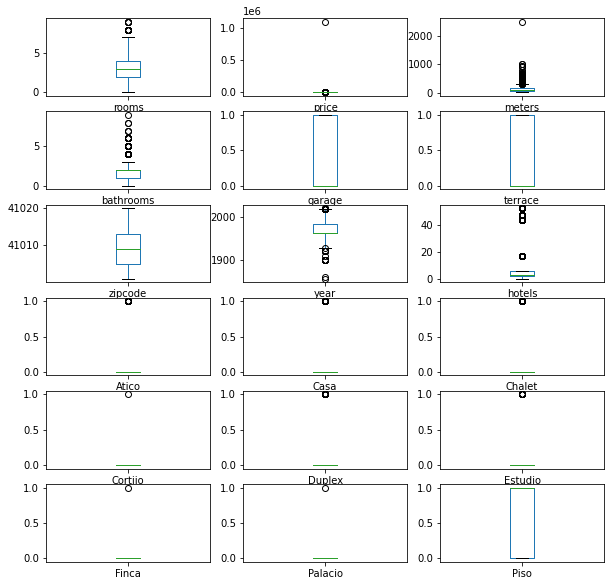

In [77]:
df.plot(kind="box", subplots=True, layout=(6,3), figsize=(10,10))

In [78]:
df[df['meters']>2000]

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Cortijo,Duplex,Estudio,Finca,Palacio,Piso
448,"Cortijo en Bellavista, Sevilla",1,4500.0,2500,1,1,1,41014,1962,3,0,0,0,1,0,0,0,0,0


Destaca una única entrada, con más de 2000 metros, que es de tipo Cortijo, y es un único elemento en todo el conjunto de datos. Es un buen candidato para retirarse del conjunto, así como para proceder, por ende, a retirar la columna "Cortijo", ya que se trata de la única fila presente de este tipo.

In [79]:
df[df['Cortijo']>0]

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Cortijo,Duplex,Estudio,Finca,Palacio,Piso
448,"Cortijo en Bellavista, Sevilla",1,4500.0,2500,1,1,1,41014,1962,3,0,0,0,1,0,0,0,0,0


In [80]:
df = df.loc[(df['Cortijo']<1)]
df.drop('Cortijo', axis=1, inplace=True)

C:\Users\Javier\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Haciendo un chequeo de los otros tipos, finca y palacio también tienen una única entrada, por lo que vamos a proceder a retirarlos del dataset, al igual que hicimos con el Cortijo.

In [81]:
df = df.loc[(df['Finca']<1)]
df = df.loc[(df['Palacio']<1)]
df.drop('Finca', axis=1, inplace=True)
df.drop('Palacio', axis=1, inplace=True)

In [82]:
df.head(5)

,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Duplex,Estudio,Piso
0,"Ático en Arenal - Museo, Sevilla",4,750.0,165,2,0,1,41001,1962,48,1,0,0,0,0,0
1,"Ático en Arenal - Museo, Sevilla",1,298.0,80,1,0,1,41001,1962,48,1,0,0,0,0,0
2,"Ático en Asunción - Adolfo Suárez, Sevilla",2,550.0,175,2,0,0,41011,2013,2,1,0,0,0,0,0
3,"Ático en avenida de Kansas City, Luis Montoto ...",4,300.0,150,2,0,1,41018,1962,5,1,0,0,0,0,0
4,"Ático en calle Alfalfa, Santa Cruz - Alfalfa, ...",0,114.0,24,1,0,1,41004,1980,53,1,0,0,0,0,0


Si ahora volvemos a ejecutar los boxplots, veremos que hemos equilibrado algo más los datos

rooms           AxesSubplot(0.125,0.749828;0.227941x0.130172)
price        AxesSubplot(0.398529,0.749828;0.227941x0.130172)
meters       AxesSubplot(0.672059,0.749828;0.227941x0.130172)
bathrooms       AxesSubplot(0.125,0.593621;0.227941x0.130172)
garage       AxesSubplot(0.398529,0.593621;0.227941x0.130172)
terrace      AxesSubplot(0.672059,0.593621;0.227941x0.130172)
zipcode         AxesSubplot(0.125,0.437414;0.227941x0.130172)
year         AxesSubplot(0.398529,0.437414;0.227941x0.130172)
hotels       AxesSubplot(0.672059,0.437414;0.227941x0.130172)
Atico           AxesSubplot(0.125,0.281207;0.227941x0.130172)
Casa         AxesSubplot(0.398529,0.281207;0.227941x0.130172)
Chalet       AxesSubplot(0.672059,0.281207;0.227941x0.130172)
Duplex             AxesSubplot(0.125,0.125;0.227941x0.130172)
Estudio         AxesSubplot(0.398529,0.125;0.227941x0.130172)
Piso            AxesSubplot(0.672059,0.125;0.227941x0.130172)
dtype: object

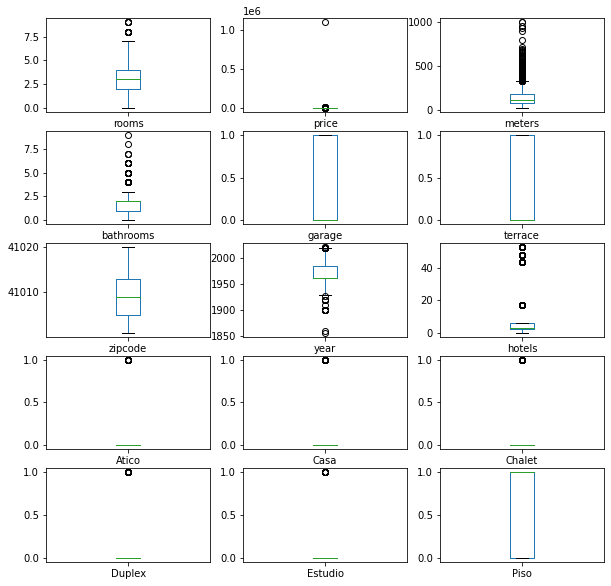

In [83]:
df.plot(kind="box", subplots=True, layout=(5,3), figsize=(10,10))

**4. Análisis de los datos.**

**4.1. Selección de los grupos de datos que se quieren analizar/comparar (p. e., si se
van a comparar grupos de datos, ¿cuáles son estos grupos y qué tipo de análisis
se van a aplicar?)**

Resultará de enorme interés tener en cuenta los siguientes grupos de datos al analizar / comparar:

* Viviendas **según el tipo**  (comparar chalets, pisos, duplex etc entre sí).
* Viviendas **según el código postal**.

Si fuésemos un Grupo Inmobiliario o una Promotora, resultaría de enorme interés realizar los siguientes análisis:


1. **Regresiones**. Determinar el precio adecuado para una nueva vivienda a vender, teniendo en cuenta el precio del resto.
2. Si queremos realizar una construcción nueva, y queremos elegir la mejor ubicación para ello, puede ser interesante aplicar algún **modelo de clasificación**, que escoja el mejor barrio en función de los parámetros de la vivienda (metros cuadrados, tipo de vivienda, número de habitaciones y precio al que se quiere establecer, por ejemplo).


**4.2. Comprobación de la normalidad y homogeneidad de la varianza.**

Para **comprobar la normalidad de los datos** en variables cuantitativas (price, meters), se recurrirá al **test de Anderson-Darling**. 


In [84]:
from scipy.stats import anderson

# tomamos una muestra aleatoria de 50 samples
cuantitatives = df[['price', 'meters']].sample(frac=50, replace=True).reset_index(drop=True)

for cuantitative in cuantitatives.columns:
    print(anderson(cuantitatives[cuantitative]))

AndersonResult(statistic=34698.86155745399, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=6354.180749832987, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


Como para cualquier valor de α (significance_level) resulta que el estadístico (34659 para price, 6408 para meters) es mucho más alto que los valores críticos, sin importar el nivel de significancia que se elija, podemos rechazar la hipótesis nula de la prueba. Tenemos pruebas suficientes para decir que **los datos de la muestra no se distribuyen normalmente**. 

Seguidamente, pasamos a estudiar la homogeneidad de varianzas mediante la aplicación de
un test de Fligner-Killeen. En este caso, estudiaremos esta homogeneidad en cuanto a
el conjunto de viviendas de tipo "Piso" frente al resto.

In [85]:
from scipy.stats import fligner

# definimos grupos
pisos = df[df['Piso']>0]['price']
no_pisos = df[~df['Piso']>0]['price']

stat, p = fligner(pisos, no_pisos)
print(p)

6.8674887984333595e-12


Un valor tan pequeño de p apunta a que las poblaciones no tienen varianzas iguales. 

No resulta algo sorprendente, debido a que la varianza de las viviendas que son pisos es mucho mayor que la de las viviendas que no lo son

In [86]:
[np.var(x, ddof=1) for x in [pisos, no_pisos]]

[928196882.1239911, 656947421.2661272]

**4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos. En función
de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis,
correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis
diferentes.**

Un buen primer análisis a realizar es el de la correlación de las variables, para ver cuáles pueden estar ejerciendo una mayor influencia en el precio de la vivienda. 

In [87]:
df.corr()

,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Duplex,Estudio,Piso
rooms,1.000000,0.016499,0.529431,0.568066,0.205469,0.285613,0.045577,-0.153894,-0.012517,-0.036800,0.226372,0.261100,-0.084753,-0.219393,-0.229739
price,0.016499,1.000000,0.029402,0.033549,0.035588,0.026998,0.012095,-0.027471,-0.007281,-0.002224,-0.000913,-0.008716,-0.004154,-0.003027,0.010871
meters,0.529431,0.029402,1.000000,0.718136,0.234974,0.221172,-0.082395,-0.148406,0.152897,-0.014786,0.381637,0.369262,-0.033248,-0.085397,-0.447806
bathrooms,0.568066,0.033549,0.718136,1.000000,0.282109,0.271489,-0.083603,-0.041091,0.152325,-0.009527,0.284494,0.238635,0.042920,-0.092348,-0.326195
garage,0.205469,0.035588,0.234974,0.282109,1.000000,0.173438,0.267976,0.266921,-0.083760,0.000260,0.087129,0.100526,0.022056,-0.068126,-0.119551
terrace,0.285613,0.026998,0.221172,0.271489,0.173438,1.000000,0.046834,0.039274,-0.056998,0.116899,0.073862,0.121865,0.028897,-0.092182,-0.163611
zipcode,0.045577,0.012095,-0.082395,-0.083603,0.267976,0.046834,1.000000,0.183864,-0.600731,-0.061803,-0.061138,0.111825,-0.119218,-0.047626,0.011743
year,-0.153894,-0.027471,-0.148406,-0.041091,0.266921,0.039274,0.183864,1.000000,-0.100481,0.012756,-0.075788,-0.130405,0.064612,0.064901,0.099508
hotels,-0.012517,-0.007281,0.152897,0.152325,-0.083760,-0.056998,-0.600731,-0.100481,1.000000,0.079042,0.022213,-0.023970,0.115434,0.049095,-0.072539
Atico,-0.036800,-0.002224,-0.014786,-0.009527,0.000260,0.116899,-0.061803,0.012756,0.079042,1.000000,-0.028795,-0.063719,-0.027452,-0.013043,-0.210251


In [92]:
y = df.price
X = df.drop(['tittle','price'],axis = 1)

De la tabla anterior, se extraen las siguientes conclusiones:

* Tal y como era de esperar, el código postal y el número de hoteles están correlacionados. Cuanto más bajo es el código postal (ej: 41001, que pertenece a la extensión del centro histórico) mayor es el número de hoteles en la zona. Es por este motivo que aparece como negativo (-0.6).

* El número de baños está fuertemente relacionado con la cantidad de metros (0.71), cosa que también tiene todo el sentido: a mayor superficie, mayor será el número de baños o aseos distribuidos. 

* La correlación también es muy fuerte entre el número de baños y el número de habitaciones (cuantas más personas habitando en un hogar, mayor será el número de baños también).

* Los metros cuadrados también están muy correlacionados con el número de habitaciones. 

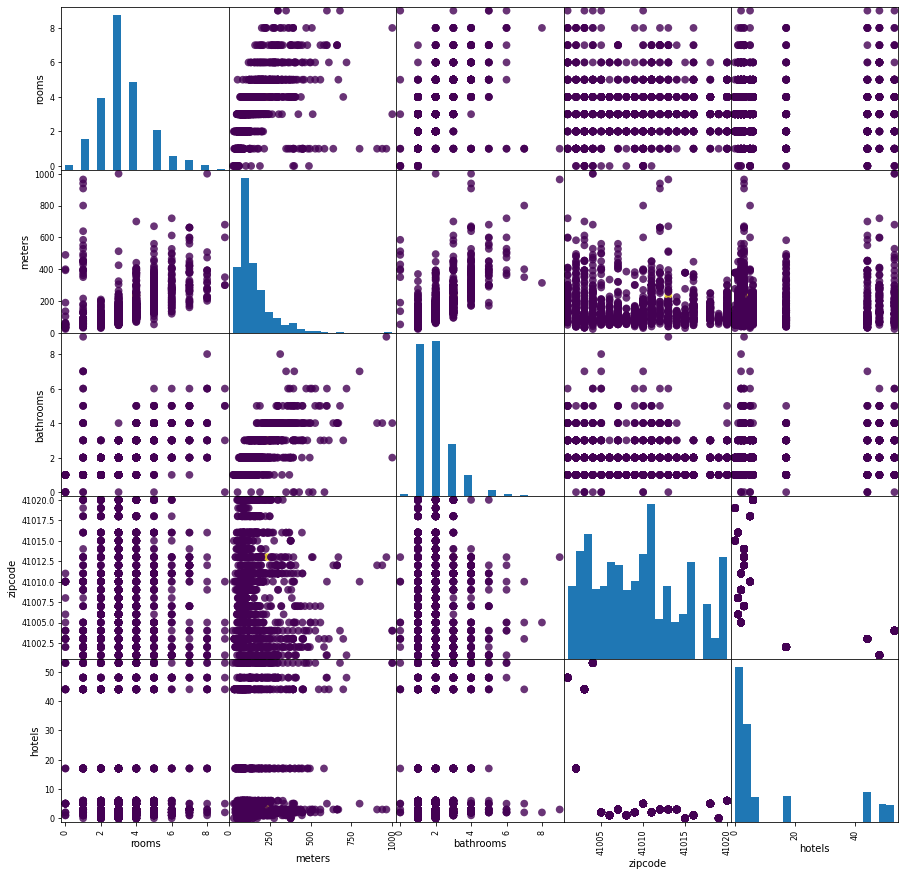

In [93]:
#Otra forma de visualizar la correlación
interesting_features = [ 'rooms',
 'meters',
 'bathrooms',
 'zipcode',
 'hotels',]
view_scatter = pd.DataFrame(df, columns=interesting_features)
sp = pd.plotting.scatter_matrix(view_scatter, c=df.price, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

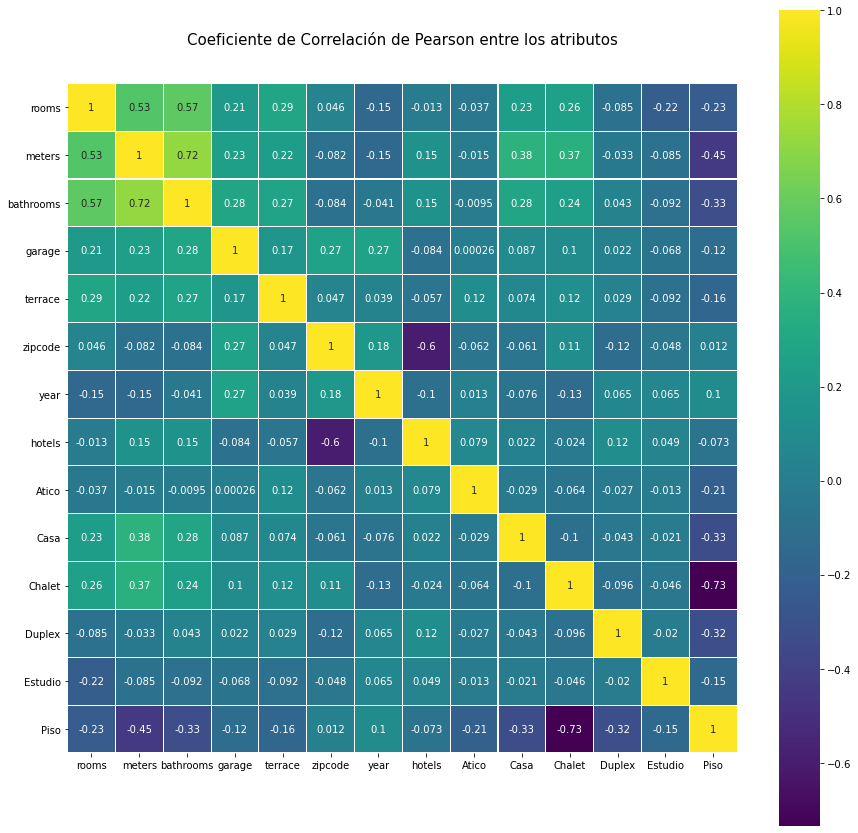

In [94]:
plt.figure(figsize=(15,15))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(X.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='viridis', linecolor='white', annot=True)

In [95]:
X.head()

,rooms,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Duplex,Estudio,Piso
0,4,165,2,0,1,41001,1962,48,1,0,0,0,0,0
1,1,80,1,0,1,41001,1962,48,1,0,0,0,0,0
2,2,175,2,0,0,41011,2013,2,1,0,0,0,0,0
3,4,150,2,0,1,41018,1962,5,1,0,0,0,0,0
4,0,24,1,0,1,41004,1980,53,1,0,0,0,0,0


El objetivo inicial es predecir los precios de las casas. Separamos y como tal, y X como el resto de parámetros numéricos, excluyendo por tanto el precio y el campo tittle

In [96]:
y.head()

0    750.0
1    298.0
2    550.0
3    300.0
4    114.0
Name: price, dtype: float64

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1233, 14)
(608, 14)
(1233,)
(608,)


In [98]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

Clarificar que, para medir la calidad de las regresiones que van a hacerse a continuación, además del error cuadrático medio, se utilizará R-cuadrado.
$$R^2$$
El R^2 es una medida estadística de qué tan cerca están los datos de la línea de regresión ajustada. También se conoce como coeficiente de determinación, o coeficiente de determinación múltiple si se trata de regresión múltiple.
representa la proporción de varianza de Y explicada por las variables implicadas en el modelo de regresión ajustado a los datos (X en el modelo de regresión lineal simple). En cuanto que una razón, este coeficiente oscilará siempre entre 0 y 1, de modo que cuanto más próximo sea R2 a 1, indicará mejor bondad de ajuste del modelo de regresión a la
distribución conjunta de las variables. Si R2 es igual a 1, el ajuste será perfecto. 

$$R^2 = \frac{V_{explicada}}{V_{total}}$$



La definición de R-cuadrado es bastante sencilla: es el porcentaje de la variación en la variable de respuesta que es explicado por un modelo lineal. Es decir:

0% indica que el modelo no explica ninguna porción de la variabilidad de los datos de respuesta en torno a su media.
100% indica que el modelo explica toda la variabilidad de los datos de respuesta en torno a su media.
En general, cuanto mayor es el R-cuadrado, mejor se ajusta el modelo a los datos. 


In [99]:
def model_performance(X_train, y_train, X_test, y_test, lin_model):
# model evaluation for training set
    y_train_predict = lin_model.predict(X_train)
    rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
    r2 = r2_score(y_train, y_train_predict)

    print("The model performance for training set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

    # model evaluation for testing set
    y_test_predict = lin_model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
    r2 = r2_score(y_test, y_test_predict)

    print("The model performance for testing set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    
    return y_train_predict, y_test_predict

y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, lin_model)

The model performance for training set
--------------------------------------
RMSE is 156.6441183999523
R2 score is 0.7760263800149032


The model performance for testing set
--------------------------------------
RMSE is 44587.225935503775
R2 score is -0.0011389523776093036


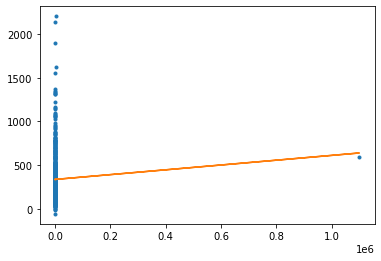

In [100]:
def plot_regression(y_test,y_test_predict):
    m, b = np.polyfit(y_test, y_test_predict, 1)
    plt.plot(y_test, y_test_predict, '.')
    plt.plot(y_test, b + m * y_test, '-')
    #plt.plot(y_test_predict, X_test, color='red')
    plt.show()
plot_regression(y_test,y_test_predict)

A continuación, probaremos con **modelos regularizados**, en concreto **Lasso**. 



In [101]:
clf = linear_model.Lasso(alpha=120)

clf.fit(X_train, y_train)
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, clf)

The model performance for training set
--------------------------------------
RMSE is 175.3649672549018
R2 score is 0.7192922774749166


The model performance for testing set
--------------------------------------
RMSE is 44590.80367913481
R2 score is -0.0012996245046881238


Aquí, α (alfa) es el parámetro que equilibra la cantidad de énfasis que se da a la minimización del RSS (*residual sum squares*) frente a la minimización de la suma del cuadrado de los coeficientes. α puede tomar varios valores:

* α = 0:<br>
El objetivo se convierte en el mismo que la regresión lineal simple.<br>
Obtendremos los mismos coeficientes que la regresión lineal simple.<br>
* α = ∞:<br>
Los coeficientes serán cero. ¿Por qué? Debido al peso infinito en el cuadrado de los coeficientes, cualquier cosa menos de cero<br> hará que el objetivo sea infinito.<br>
* 0 < α < ∞:<br>
La magnitud de α decidirá el peso dado a las diferentes partes del objetivo.<br>
Los coeficientes estarán entre 0 y 1 para la regresión lineal simple.<br>

Después de hacer varias pruebas, se ha visto que con un α = 120 se obtiene una RMSE y R2 algo mejores, aunque el cambio no es muy significativo.

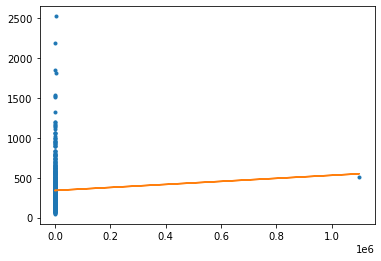

In [102]:
plot_regression(y_test,y_test_predict)

Ahora probaremos con **Ridge**, y distintos valores de alpha. El mejor valor encontrado se dejará indicado.

In [103]:
ridge_model = linear_model.Ridge(alpha=900) # alpha 900

ridge_model.fit(X_train, y_train)
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, ridge_model)

The model performance for training set
--------------------------------------
RMSE is 165.84249428575544
R2 score is 0.7489499422506861


The model performance for testing set
--------------------------------------
RMSE is 44590.35112782551
R2 score is -0.0012793002620536953


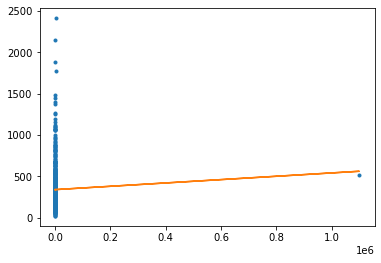

In [104]:
plot_regression(y_test,y_test_predict)

In [105]:
regr = RandomForestRegressor(max_depth=11, random_state=9)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, random_state=9)

In [106]:
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, regr)

The model performance for training set
--------------------------------------
RMSE is 57.68791798321153
R2 score is 0.9696234523555637


The model performance for testing set
--------------------------------------
RMSE is 44585.27648025008
R2 score is -0.0010514101327807612


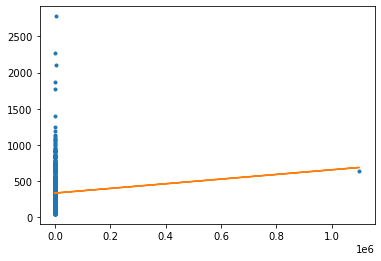

In [107]:
plot_regression(y_test,y_test_predict)

In [108]:
reg = linear_model.LassoLarsIC(criterion='aic')

# fit the model with data
reg.fit(X_train,y_train)

LassoLarsIC()

In [109]:
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, reg)

The model performance for training set
--------------------------------------
RMSE is 157.7148794715898
R2 score is 0.7729539135384953


The model performance for testing set
--------------------------------------
RMSE is 44587.91513677307
R2 score is -0.0011699025681590758


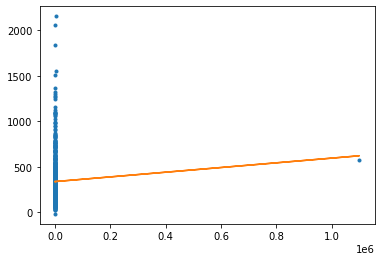

In [110]:
plot_regression(y_test,y_test_predict)

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html

A continuación, queremos aplicar regresión logística a los precios. Sin embargo, tenemos el problema de que no se aceptan variables de tipo float. Lo más sencillo sería forzar la conversión a ints, como se ha hecho anteriormente, pero echando un vistazo a la documentación, una buena práctica consiste en utilizar label encoders para arreglarlo.

In [111]:
y_encoded = preprocessing.LabelEncoder()
y_encoded.fit(y)

LabelEncoder()

In [112]:
X.head()

,rooms,meters,bathrooms,garage,terrace,zipcode,year,hotels,Atico,Casa,Chalet,Duplex,Estudio,Piso
0,4,165,2,0,1,41001,1962,48,1,0,0,0,0,0
1,1,80,1,0,1,41001,1962,48,1,0,0,0,0,0
2,2,175,2,0,0,41011,2013,2,1,0,0,0,0,0
3,4,150,2,0,1,41018,1962,5,1,0,0,0,0,0
4,0,24,1,0,1,41004,1980,53,1,0,0,0,0,0


<font color='red'>**Advertencia**</font>: este modelo tarda unos minutos en converger, no es algo inmediato.

In [113]:
clf = linear_model.LogisticRegression(random_state=0,dual=False,max_iter=120000).fit(X, y_encoded.transform(y))

In [116]:
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, clf)

The model performance for training set
--------------------------------------
RMSE is 252.2422522551345
R2 score is 0.41922975898214


The model performance for testing set
--------------------------------------
RMSE is 44589.16855443506
R2 score is -0.00122619143803826


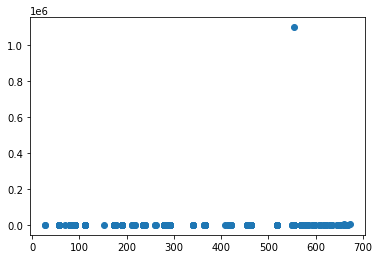

In [117]:
y_values = [1 / (1 + np.exp(-x)) for x in y_test_predict]
plt.scatter(y_test_predict, y_test)

¿Y si hiciésemos regresión sólo para los pisos? Anteriormente vimos que eran los tipos de anuncio que más se repetían. Vamos a volver a leer el dataset y analizar qué resultados nos arrojaría

In [118]:
df = pd.ExcelFile("Sevilla_housing.xlsx").parse("Sheet1")
filas, columnas = df.shape
print(f'El corpus de viviendas posee {filas} filas y {columnas} columnas')
df=clean_prices(df)
convert_rows_to_int(df)
df['house_type']=df['tittle'].str.split().str.get(0)
df['house_type']=df['house_type'].str.replace('Ático','Atico').str.replace('Dúplex','Duplex')

print(list(df['house_type'].str.split().str.get(0).unique()))
pisos = df[df['house_type']=='Piso']
pisos = pisos.drop('house_type',axis = 1)
filas, columnas = pisos.shape

print(f'El corpus de pisos posee {filas} filas y {columnas} columnas')
pisos.head()

El corpus de viviendas posee 1844 filas y 10 columnas
['Atico', 'Casa', 'Chalet', 'Cortijo', 'Duplex', 'Estudio', 'Finca', 'Palacio', 'Piso']
El corpus de pisos posee 1303 filas y 10 columnas


,tittle,rooms,price,meters,bathrooms,garage,terrace,zipcode,year,hotels
541,"Piso en Adriano, Arenal - Museo, Sevilla",5,850.0,252,3,0,1,41001,1975,48
542,"Piso en aguila perdicera, 11, Su Eminencia - L...",3,133.5,97,2,0,1,41006,2019,1
543,"Piso en Aguila Perdicera, 9, Su Eminencia - La...",3,145.0,97,2,0,1,41006,2020,1
544,"Piso en alameda de Hércules, Alameda, Sevilla",2,310.0,85,2,0,0,41002,2010,17
545,"Piso en alameda, s/n, Alameda, Sevilla",2,360.0,90,2,0,0,41002,2008,17


Corroboramos si hay algún outlier, como en el caso anterior. Parece que no, ya que el más caro es de millón y medio de €

In [119]:
max(pisos['price'])

1100000.0

Veamos la distribución de pisos por barrios... ¿En qué código postal se venden más pisos?

In [120]:
def assign_hood(zipcode):
    if zipcode == 41001:
        val = 'Arenal-Museo'
    if zipcode ==41011:
        val = 'Tablada'
    if zipcode ==41018:
        val = 'La Buhaira'
    if zipcode ==41004:
        val = 'San Bernardo'
    if zipcode ==41004:
        val = 'San Bernardo'
    if zipcode ==41010:
        val = 'Triana/Los Remedios'
    if zipcode ==41003:
        val = 'Feria'
    if zipcode ==41009:
        val = 'Polígono Norte'
    if zipcode ==41013:
        val = 'La Palmera-Los Bermejales-Prado San Sebastián-Felipe II-Bueno Monreal'
    if zipcode ==41002:
        val = 'San Vicente-San Lorenzo-San Gil-Alameda'
    if zipcode ==41014:
        val = 'Bellavista'
    if zipcode ==41012:
        val = 'Heliópolis'
    if zipcode ==41005:
        val = 'Nervión'
    if zipcode ==41008:
        val = 'La Rosaleda'
    if zipcode ==41020:
        val = 'Valdezorras'
    if zipcode ==41015:
        val = 'Sevilla Norte'
    if zipcode ==41007:
        val = 'San Pablo-Santa Clara'
    if zipcode ==41006:
        val = 'Cerro-Amate'
    if zipcode ==41016:
        val = 'Torreblanca'
    if zipcode ==41019:
        val = 'Sevilla Este'
    return val

In [121]:
#using Plotly
hood=[]
#pisos['zipcode'] = pisos['zipcode'].astype(int)
for index, row in pisos.iterrows():
    hood.append(assign_hood(row['zipcode']))
pisos['hood']=hood
fig = px.histogram(pisos, x="hood",title="Distribución de anuncios de pisos por barrios")
fig.show()

In [122]:
pisos = pisos.drop('hood',axis = 1)
pisos = pisos.drop('tittle',axis = 1)

In [123]:
pisos_prices = pisos['price']
pisos = pisos.drop('price',axis = 1)

Vamos a volver a aplicar una regresión lineal para los pisos.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(pisos, pisos_prices, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(873, 8)
(430, 8)
(873,)
(430,)


In [125]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, y_train)
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, lin_model)

The model performance for training set
--------------------------------------
RMSE is 36969.20505741257
R2 score is 0.012319402293904269


The model performance for testing set
--------------------------------------
RMSE is 4497.150864185842
R2 score is -459.6981826729205


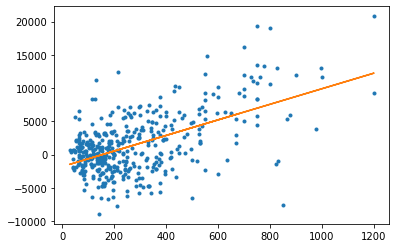

In [126]:
plot_regression(y_test,y_test_predict)

La medida R2 ha mejorado ligeramente, pero no parece que hayamos obtenido muy buenos resultados con una simple regresión lineal. Con Lasso no mejora mucho. Con Ridge tampoco.

In [129]:
clf = linear_model.Lasso(alpha=20)

clf.fit(X_train, y_train)
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, clf)

The model performance for training set
--------------------------------------
RMSE is 36969.302855821494
R2 score is 0.012314176662538756


The model performance for testing set
--------------------------------------
RMSE is 4446.956941214444
R2 score is -449.47161844399756


In [130]:
ridge_model = linear_model.Ridge(alpha=10) # alpha 900

ridge_model.fit(X_train, y_train)
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, ridge_model)

The model performance for training set
--------------------------------------
RMSE is 36969.42245383783
R2 score is 0.012307786200875359


The model performance for testing set
--------------------------------------
RMSE is 4421.526242409218
R2 score is -444.3341493019024


Con Random Forest volvemos a obtener algo más de precisión. Para pisos, una R2 de 0.7

In [131]:
regr = RandomForestRegressor(max_depth=10, random_state=22)
regr.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
y_train_predict, y_test_predict = model_performance(X_train, y_train, X_test, y_test, regr)

The model performance for training set
--------------------------------------
RMSE is 20155.198286073126
R2 score is 0.7064308276940818


The model performance for testing set
--------------------------------------
RMSE is 9380.683504066434
R2 score is -2003.5207314750064


No parece que podamos mejorar mucho los resultados con técnicas de regresión, pero si tuviésemos que elegir alguna de las técnicas revisadas, nos quedamos sin duda con **Random Forest** como la mejor. Vamos a explorar el corpus desde un punto de vista categórico nuevamente, donde vamos a intentar ahora clasificar el barrio al que pertenezca la casa según el resto de factores (precio, número de habitaciones, garaje, ...). También podríamos buscar de qué tipo de vivienda se trata según las propiedades que tiene.

**Análisis del corpus de viviendas desde un punto de vista categórico: Árboles de decisión**<br>

**Objetivo**: Averiguar de qué tipo de vivienda se trata la casa según su código postal, metros o número de habitaciones.

In [132]:
df = pd.ExcelFile("Sevilla_housing.xlsx").parse("Sheet1")
filas, columnas = df.shape
print(f'El corpus de viviendas posee {filas} filas y {columnas} columnas')
df=clean_prices(df)
convert_rows_to_int(df)
df['house_type']=df['tittle'].str.split().str.get(0)
df['house_type']=df['house_type'].str.replace('Ático','Atico').str.replace('Dúplex','Duplex')

El corpus de viviendas posee 1844 filas y 10 columnas


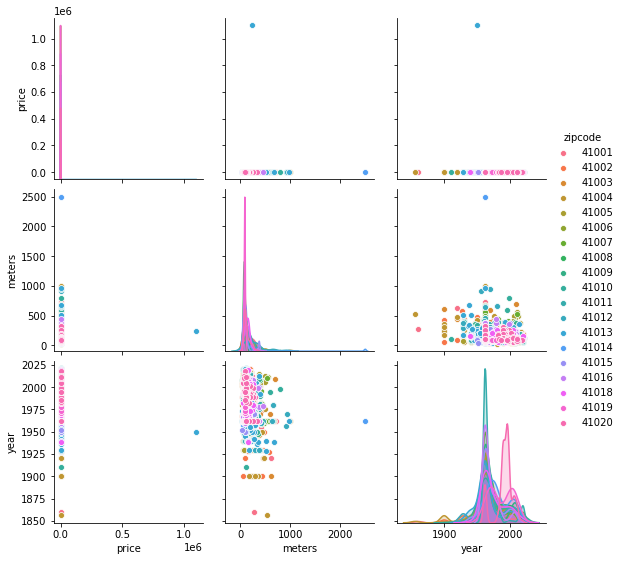

In [133]:
g = sns.pairplot(df, vars=["price", "meters","year"], hue="zipcode")
plt.show(g)

In [134]:
print(df['house_type'].unique())
df['house_type'] = pd.factorize(df.house_type)[0]
print(df['house_type'].unique())

['Atico' 'Casa' 'Chalet' 'Cortijo' 'Duplex' 'Estudio' 'Finca' 'Palacio'
 'Piso']
[0 1 2 3 4 5 6 7 8]


In [135]:
from sklearn.model_selection import train_test_split
import numpy as np
labels = pd.factorize(df.house_type)[0]
df = df.drop('hotels',axis = 1)
df = df.drop('tittle',axis = 1)
df = df.drop('house_type',axis = 1)
features = df

In [136]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.3,
    random_state=42,
)

In [137]:
clf = tree.DecisionTreeClassifier()
clf.fit(X=X_train, y=y_train)
clf.feature_importances_ 
clf.score(X=X_test, y=y_test) 

0.7418772563176895

In [138]:
y_pred = clf.predict(X_test)

In [139]:
model_text = export_text(clf, feature_names=list(features.columns))
print(model_text)

|--- meters <= 124.50
|   |--- rooms <= 0.50
|   |   |--- year <= 1960.00
|   |   |   |--- class: 2
|   |   |--- year >  1960.00
|   |   |   |--- meters <= 27.00
|   |   |   |   |--- class: 0
|   |   |   |--- meters >  27.00
|   |   |   |   |--- class: 5
|   |--- rooms >  0.50
|   |   |--- price <= 664.90
|   |   |   |--- year <= 1958.50
|   |   |   |   |--- zipcode <= 41013.50
|   |   |   |   |   |--- meters <= 96.50
|   |   |   |   |   |   |--- meters <= 53.50
|   |   |   |   |   |   |   |--- zipcode <= 41004.00
|   |   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |   |   |--- zipcode >  41004.00
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- meters >  53.50
|   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |--- meters >  96.50
|   |   |   |   |   |   |--- meters <= 106.50
|   |   |   |   |   |   |   |--- meters <= 102.00
|   |   |   |   |   |   |   |   |--- price <= 255.00
|   |   |   |   |   |   |   |   |   |--- class: 8
|   |   

In [140]:
export_graphviz(
    clf,
    out_file="tree.dot",
    feature_names=features.columns,
    rounded=True,
    filled=True)

In [141]:
!dot -Tpng tree.dot -o tree.png

El árbol que queda es demasiado grande y complejo. Habría que aplicar alguna técnica de poda para simplificarlo, aunque perdiésemos algo de precisión.

<img src="tree.png" style="width: 700px;"/>

**Árbol de decisión aplicando prepoda**

In [142]:
# Creamos el clasificador con una profundidad máxima de 4 nodos
clf = tree.DecisionTreeClassifier(max_depth=4)
clf.fit(X=X_train, y=y_train)
clf.feature_importances_ 
print(clf.score(X=X_test, y=y_test) ) # este score corresponda al accuracy del modelo
y_pred = clf.predict(X_test)

0.7851985559566786


La puntuación obtenida es mucho mejor, y el árbol queda muchísimo más sencillo y legible. Después de jugar con varias profundidades máximas, nos quedamos con la de 4 nodos.

In [143]:
export_graphviz(
    clf,
    out_file="tree_prepoda.dot",
    feature_names=features.columns,
    rounded=True,
    filled=True)

In [145]:
!dot -Tpng tree_prepoda.dot -o tree_prepoda.png

<img src="tree_prepoda.png" style="width: 700px;"/>

**5. Representación de los resultados a partir de tablas y gráficas. Este apartado se puede
responder a lo largo de la práctica, sin necesidad de concentrar todas las
representaciones en este punto de la práctica** (YA SE HA IDO REALIZANDO EN LOS APARTADOS ANTERIORES)

**6. Resolución del problema. A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?**

A pesar de que hemos tratado de limpiar el dataset de outliers, y aplicando técnicas como one hot encoding para una mejor elaboración de modelos, hemos visto que aplicar regresiones resulta poco útil cuando analizamos todos los tipos de vivienda a la vez. Sin embargo, realizar regresiones sobre cada tipo de vivienda (tal y como se ha hecho con las de tipo Piso), ha dado un mejor resultado, y pueden aportar, con limitaciones, un buen precio aproximado del inmueble. 

Realizando el ejercicio inverso, tratar de averiguar el barrio al que pertenece la vivienda según sus características, ha arrojado unos mejores resultados recurriendo a árboles de decisión, y utilizando técnicas para su simplificación, como la poda.
Tal y como se indicaba, esto puede ser de mucha utilidad para promotoras y emprendedores que quieren edificar nuevas viviendas en la ciudad, ya que les permitiría decidir, según lo que quisiesen construir, cuál es la zona que mejor se adaptaría a ello.

Resultaría de tremendo interés observar la evolución de los precios en el tiempo, como una tercera herramienta a aportar para las Inmobiliarias, con el fin de poder predecir cuál es el mejor momento para anunciar la vivienda, porque su precio esté más alto (y por ende, se saque mayor beneficio). Para este propósito, sería necesario realizar extracciones periódicas (por ejemplo mensuales) y tener muy en cuenta algunas de las limitaciones que presenta la fuente de datos (anuncios duplicados, por ejemplo: muchos usuarios publican periódicamente la misma vivienda alterando ligeramente el precio final, a fin de aparecer más veces en los resultados de búsqueda).



**7. Código: Hay que adjuntar el código, preferiblemente en R, con el que se ha realizado la limpieza, análisis y representación de los datos. Si lo preferís, también podéis trabajar en Python.** (YA SE HA IDO MOSTRANDO EL CÓDIGO EN LOS APARTADOS ANTERIORES)
